# Spam Filter

Name: Elias Zischg

Date: 03.01.2025

Assignment: Design a spam filter using the 'Apache Assassin`s public dataset'. The procedure requires data cleaning, splitting the data into training and test set, vectorizing the data and finally trying out different classifiers, while checking both recall and precision.

This project extracts the Headers and Body of the emails and stores them in a pandas Dataframe. Additionally the emails get labels with ones and zeros, so that the classifiers can be used. I than clean the data using regualr expression and convert the data into a sparse vector, while doing further data cleaning. Afterwards the data gets split into training and test sets, where I use five different classifiers to chekc which one has the best Precision- and Recall scores, alongside the Accuracy. I also try if a Voting Classifier consisting of all the classifiers combined gets better results. Furthermore I plot and compare the Confusion Matrix for both the training and test sets of the Voting Classifier and the single Classifier with the highest scores.

### This is my solution to the Data Science assignment: 'Designing a Spam Filter' 

First I import all the necessary libraries. The first 5 are for data cleaning and the others are the sklearn libraries for the data splitting, the classifiers and the precision- and recoil scores. 

After the imports I wrote a function which opens and reads the header and body of the email. I also cheack for HTML tags in the body and remove them. Then I return the email`s header and body. 

In [1]:
import pandas as pd
import numpy as np
import os
import email
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score



def extract_email(file_path):
    """
    Read each email in the directory & parse email info
    Path: Variable used to define folder location
    """
    with open(file_path, 'rb') as f:
        msg = email.message_from_bytes(f.read())
        
    # Get email headers
    headers = msg.get('Headers')
    
    # Read email’s body
    body = str(msg.get_payload())
    
    # Check if body contains HTML tags
    if '<' in body and '>' in body:
        # Remove HTML tags if it's valid markup
        body = BeautifulSoup(body, features='html.parser').get_text()
    return headers, body

After getting the headers and body of the emails I want to convert them into a dataframe, so I can use them for the classifiers. I want the dataframe to have the email with labels. Therefore I first write a function that iterates through the whole dataset folders, extracts them using the function from above and adds them to the dataframe. Afterwards I than add another column to the dataframe, where I convert ham into zeros and spam into ones, so I have the lables as numbers. Next the labels are added into the dataframes and both are combined with the *.concat* function, so I get one dataframe containing all the email with their respective labels. I also check that the labels are integers and not strings, which makes it easier to handle afterwards. Then I clean up the emails using regular expressions.

In [2]:
ham_path = '../../dataset/easy_ham'
spam_path = '../../dataset/spam'


ham = []
spam = []

def email_to_dataframe(directory_path, list):
    for file in os.listdir(directory_path):
        file_path = f"{directory_path}/{file}"
        each_email = extract_email(file_path)
        list.append(each_email)

email_to_dataframe(ham_path, ham)
email_to_dataframe(spam_path, spam)

ham_0 = pd.Series(np.zeros(len(ham)))
spam_1 = pd.Series(np.ones(len(spam)))

df_ham = pd.DataFrame()
df_ham['email'] = ham
df_ham['spam (1) or ham (0)'] = ham_0

df_spam = pd.DataFrame()
df_spam['email'] = spam
df_spam['spam (1) or ham (0)'] = spam_1

df = pd.concat([df_ham, df_spam], ignore_index=True)
df['email'] = df['email'].astype(str)
df['spam (1) or ham (0)'] = df['spam (1) or ham (0)'].astype(int)


# Preprocessing

# Remove URL
df['email'] = df['email'].str.replace(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', 'URL', regex=True)
# Remove numbers
df['email'] = df['email'].str.replace(r'\b\d+\b', 'NUMBER', regex=True)
# Remove special characters
df['email'] = df['email'].str.replace(r'[^\w\s]', '', regex=True)
# Remove extra spaces
df['email'] = df['email'].str.lower()
# Remove excess whitespace
df['email'] = df['email'].str.replace(r'\s+', ' ', regex=True).str.strip()


print(df.head())

                                               email  spam (1) or ham (0)
0  none date wed number aug number numbernumbernu...                    0
1  none martin a postedrntassos papadopoulos the ...                    0
2  none man threatens explosion in moscow rnrnthu...                    0
3  none klez the virus that wont diern rnalready ...                    0
4  none on wed aug number number at numbernumber ...                    0


After the cleaning the data and converting it to a labeled dataframe I transform the emails into a sparse vector, using the *TfidfVectorizer* from sklearn. The argument *stop_words='english'* removes stop words of the english language, for example 'and', 'the' and 'him'. It also automatically convert all characters to lower case before tokenizing (this is a default but I did it in the cleaning before anyway) and I use the *strip_accents='unicode'* argument to convert letters with accents to their closest non-accent couterparts. For example café becomes cafe. 

In [3]:
tf_idf = TfidfVectorizer(stop_words = 'english', strip_accents='unicode')

bow = tf_idf.fit_transform(df['email']).toarray()

vect = pd.DataFrame(bow, columns=tf_idf.get_feature_names_out())
vect['spam (1) or ham (0)'] = df['spam (1) or ham (0)']

Now that the data is cleaned and prepared it can be spilt into training and test data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(vect.iloc[:,:-1], vect['spam (1) or ham (0)'], test_size = 0.2)

Now I can use some classifiers. I decided to try out 5 common ones I thought would get me interesting results. I decided on trying Stochastic Gradient Descent, Naive Bayes, K-Neighbors, Logistic Regression and a Decision Tree. I make a dataframe to store the results and than loop through the classifiers and print the Precision, Recall and Accuracy. For reference it took under 40 seconds to run this cell on my PC, if it takes way longer there might be some issues. 

In [14]:
# Defining the classifiers
clf_SGD = SGDClassifier()
clf_NB = MultinomialNB()
clf_KNN = KNeighborsClassifier()
clf_LR = LogisticRegression()
clf_DT = DecisionTreeClassifier()

# Dictionary of classifiers
classifiers = {'StochasticGradientDescent': clf_SGD, 'NaiveBayes': clf_NB, 'KNeighbors': clf_KNN, 'LogisticRegression': clf_LR, 'DecisionTree': clf_DT} 

# Dataframe to store the results
results = pd.DataFrame(index = None)
results['Metric'] = ['Precision', 'Recall', 'Accuracy']

# Loop through the classifiers
for clf_name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Make predictions
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    # Collect results for training data
    precision_train = precision_score(y_train, y_pred_train)
    recall_train = recall_score(y_train, y_pred_train)
    accuracy_train = clf.score(X_train, y_train)

    # Collect results for test data
    precision_test = precision_score(y_test, y_pred_test)
    recall_test = recall_score(y_test, y_pred_test)
    accuracy_test = clf.score(X_test, y_test)

    # Append the results to the DataFrame
    results[clf_name + ' Train'] = [precision_train, recall_train, accuracy_train]
    results[clf_name + ' Test'] = [precision_test, recall_test, accuracy_test]


print(results.to_string(index=False))

   Metric  StochasticGradientDescent Train  StochasticGradientDescent Test  NaiveBayes Train  NaiveBayes Test  KNeighbors Train  KNeighbors Test  LogisticRegression Train  LogisticRegression Test  DecisionTree Train  DecisionTree Test
Precision                         1.000000                        0.988372          1.000000         1.000000          1.000000         0.933333                  1.000000                 1.000000            1.000000           0.869565
   Recall                         0.806283                        0.714286          0.170157         0.159664          0.253927         0.235294                  0.560209                 0.521008            0.808901           0.672269
 Accuracy                         0.969685                        0.942717          0.870135         0.836334          0.883245         0.847791                  0.931176                 0.906710            0.970094           0.916530


The SGD and the Decision Tree seem to get the best results with Precision Score of 1.000 and nearly the same Recall Score of 0.806 and 0.809 and Accuracy of 0.969 and 0.970 for the training data but for the test data SGD is a lot better with over 12% higher Precision, 4% higher Recall and 2.5% higher Accuracy over the Decision Tree. That´s why I would stick with the Stochastic Gradient Descent for the spam filter.

I also wanted to try a Voting Classifier to see if the Recall gets better when combining all of the classifiers. I used hard voting, because the SGD Classifier doesn´t work with soft voting, because of problems with the probability calculation.

In [22]:
# Combine them into a VotingClassifier
voting_clf = VotingClassifier(estimators=[
    ('sgd', clf_SGD),
    ('nb', clf_NB),
    ('svc', clf_KNN),
    ('lr', clf_LR),
    ('dt', clf_DT)
], voting='hard')  # 'hard' voting means majority voting

# Train the ensemble model
voting_clf.fit(X_train, y_train)

# Predictions
y_pred_train = voting_clf.predict(X_train)
y_pred_test = voting_clf.predict(X_test)

# Confusion matrix
conf_mat_train_VCL = confusion_matrix(y_train, y_pred_train)
conf_mat_test_VCL = confusion_matrix(y_test, y_pred_test)

# Collect results
results = pd.DataFrame(index = None)
results['Metric'] = ['Precision', 'Recall', 'Accuracy']
results['VotingClassifier Train'] = [
    precision_score(y_train, y_pred_train),
    recall_score(y_train, y_pred_train),
    voting_clf.score(X_train, y_train)
]
results['VotingClassifier Test'] = [
    precision_score(y_test, y_pred_test),
    recall_score(y_test, y_pred_test),
    voting_clf.score(X_test, y_test)
]

print(results.to_string(index=False))

   Metric  VotingClassifier Train  VotingClassifier Test
Precision                1.000000               1.000000
   Recall                0.602094               0.512605
 Accuracy                0.937730               0.905074


For the Voting Classifier i still get a Precision score of 1.000 for both training and test set, but much lower Recall compared to the SGD, at around 20% less for both sets. The other classifiers lower the overall score, compared to just the SGD Classifier.

I can visualize the difference in the Classifiers with learning curves and a confusion matrix. Here are the functions for plotting both.

In [21]:
def confusion_matrix_plot(conf_mat):
    n = len(conf_mat)
    plt.imshow(conf_mat, cmap='Blues', extent=[-0.5, n-0.5, -0.5, n-0.5])
    
    for i in range(n):
        for j in range(n):
            plt.text(i, j, conf_mat[n-j-1, i], ha='center', va='center')
    
    plt.colorbar()
    plt.xticks(range(n))
    plt.yticks(range(n), range(n-1, -1, -1))
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.plot


def plot_learning_curve(test_error, training_size):
    plt.plot(training_size, test_error)
    plt.title("Learning Curve")
    plt.xlabel("Training Size")
    plt.ylabel("Test Accuracy")
    plt.plot

I am plotting the Confusion Matrix for the training and test sets of the Voting Classifier.

Train Confusion Matrix Voting Classifier:


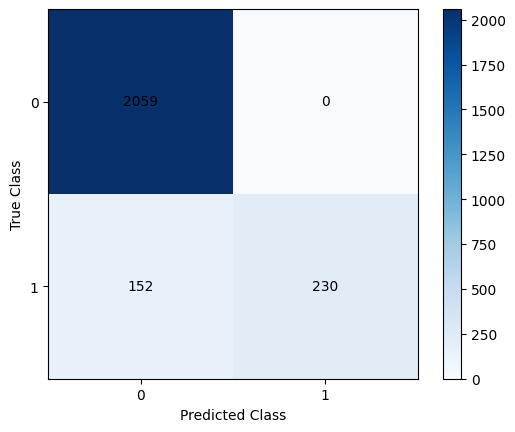

In [24]:
print("Train Confusion Matrix Voting Classifier:")
confusion_matrix_plot(conf_mat_train_VCL)


Test Confusion Matrix Voting Classifier:


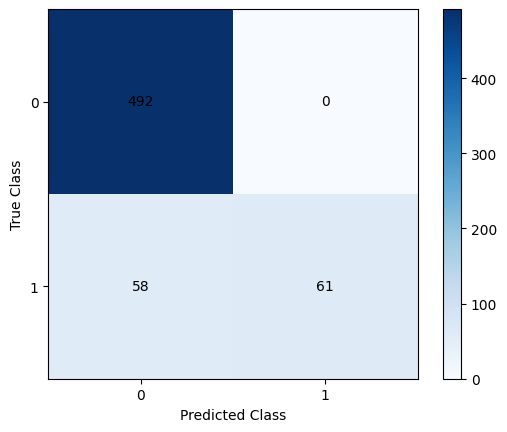

In [25]:
print("Test Confusion Matrix Voting Classifier:")
confusion_matrix_plot(conf_mat_test_VCL)

I specifically use only the SGD Classifier here to show the difference

In [26]:
clf_SGD = SGDClassifier()

clf_SGD.fit(X_train, y_train)
y_pred_train = clf_SGD.predict(X_train)
y_pred_test = clf_SGD.predict(X_test)

conf_mat_train_SGD = confusion_matrix(y_train, y_pred_train)
conf_mat_test_SGD = confusion_matrix(y_test, y_pred_test)

And here I am plotting the Confusion Matrix for the training and test sets of the Stochastic Gradient Descent Classifier.

Train Confusion Matrix SGD:


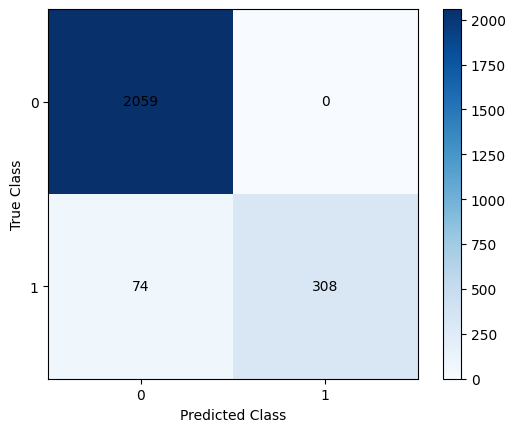

In [27]:
print("Train Confusion Matrix SGD:")
confusion_matrix_plot(conf_mat_train_SGD)

Test Confusion Matrix SGD:


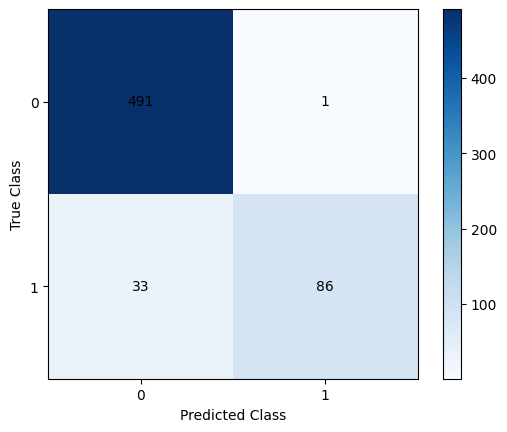

In [28]:
print("Test Confusion Matrix SGD:")
confusion_matrix_plot(conf_mat_test_SGD)

With the plots it becomes clear, that the classifiers have more problems predicting the spam emails as spam, which was also shown in the much lower Recall scores. I used the Easy Ham data, maybe if I would use the 'normal' Ham data, the Precision would also go down. It is debatable if it is worse to still get spam emails but get all of your ham emails aswell or get fewer spam emails, but than also maybe miss an important email, because the algorithm falsly detects it as spam. Overall i think especially the SGD Classifier does a good job at detecting ham and spam emails. I think there could be improvements with better data cleaning or maybe there are other classifiers, that work better with text, for example Deep Learning, where I would probalby need more time than the suggested 20 hours to implement, but could be a fun project to come back to. The sklearn library has some supervised Neural Network models that could work very well.


### DISCLAIMER: I thought about stopping here, but at this point I was having a lot of fun trying different classifiers and I want to include my honest opinion and reaction, although it might not be so professional, but I like keeping projects like this somewhat entertaining for me and hopefully also you, the reader.

Other people would maybe stop here, not me. I thought the Decision Tree was not that bad and what is better than one Decision Tree? Exactly a SVM! I would recommend looking at the results before trying the following code snippets. There might be some waiting times!

In [5]:
# Initialize the SVM classifier
clf_SVM = SVC(kernel='linear', random_state=42)

# Fit the model to the training data
clf_SVM.fit(X_train, y_train)

# Make predictions on both training and test sets
y_pred_train = clf_SVM.predict(X_train)
y_pred_test = clf_SVM.predict(X_test)

# Calculate confusion matrices
conf_mat_train = confusion_matrix(y_train, y_pred_train)
conf_mat_test = confusion_matrix(y_test, y_pred_test)

# Calculate precision, recall, and accuracy
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
accuracy_train = clf_SVM.score(X_train, y_train)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
accuracy_test = clf_SVM.score(X_test, y_test)

# Store results in a DataFrame
results = pd.DataFrame(index=None)
results['Metric'] = ['Precision', 'Recall', 'Accuracy']
results['SVM Classifier Train'] = [precision_train, recall_train, accuracy_train]
results['SVM Classifier Test'] = [precision_test, recall_test, accuracy_test]

# Print the results
print(results.to_string(index=False))

   Metric  SVM Classifier Train  SVM Classifier Test
Precision              1.000000             0.983333
   Recall              0.805288             0.694118
 Accuracy              0.966817             0.955810


SVM is not it. It took my PC 11.5 minutes to run this code. It got Precision 1.000 and 0.983, Recall 0.805 and 0.694 and an Accuracy of 0.967 and 0.956. I mean the scores are quite good, they are nearly identical with the ones from the SGD Classifier, but it took me 11 more minutes to run it, so I don`t think Space Vector MAchines are the way to go here. 

I already teasered the Random Forest, so of course I am going to try one.

In [6]:
clf_RF = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
clf_RF.fit(X_train, y_train)

# Make predictions on both training and test sets
y_pred_train = clf_RF.predict(X_train)
y_pred_test = clf_RF.predict(X_test)

# Calculate confusion matrices
conf_mat_train = confusion_matrix(y_train, y_pred_train)
conf_mat_test = confusion_matrix(y_test, y_pred_test)

# Calculate precision, recall, and accuracy
precision_train = precision_score(y_train, y_pred_train)
recall_train = recall_score(y_train, y_pred_train)
accuracy_train = clf_RF.score(X_train, y_train)

precision_test = precision_score(y_test, y_pred_test)
recall_test = recall_score(y_test, y_pred_test)
accuracy_test = clf_RF.score(X_test, y_test)

# Store results in a DataFrame
results = pd.DataFrame(index=None)
results['Metric'] = ['Precision', 'Recall', 'Accuracy']
results['RandomForestClassifier Train'] = [precision_train, recall_train, accuracy_train]
results['RandomForestClassifier Test'] = [precision_test, recall_test, accuracy_test]

# Print the results
print(results.to_string(index=False))

   Metric  RandomForestClassifier Train  RandomForestClassifier Test
Precision                      0.847251                     0.730337
   Recall                      1.000000                     0.764706
 Accuracy                      0.969275                     0.927987


After 30 seconds I got my results and they were very surprising. This is the first classifier with a better Recall than Precision score. Precision was 0.847 and 0.730, Recall at 1.000 !! and 0.765 and the Accuracy was 0.969 and 0.928. Unfortunately the results from the testset aren`t that great, otherwise this could have been a contender for the discussion about prefering Precision or Recall. 

I had a bit more time so I wanted to see if Deep Learning would get me better results. Now I am writing this before I run the code, because I think it is more genuine this way. I used a guideline from TensorFlow/Keras, so I think the code should be good to go. 

Nevermind. First I had problems because TensoFlow does not work with Python 3.12, so I tried to change to Python 3.11, which did not work. Then I made a new folder and virtual environment but somehow TensorFlow still did not want to work. So i guess that is all. Overall I had fun during this project and the whole course was great.